# Bankruptcy Prediction with Top 10 Features

This notebook identifies the top 10 most influential features for predicting company bankruptcy from the provided dataset. It then trains and evaluates a RandomForestClassifier using only these features.

The process is as follows:
1.  **Setup and Imports**: Load necessary libraries.
2.  **Data Loading and Initial Model**: Load the data and train an initial Random Forest model on all 95 features to calculate feature importance.
3.  **Feature Selection**: Identify and display the top 10 most important features.
4.  **Final Model Training**: Train a new RandomForestClassifier using only the top 10 features.
5.  **Evaluation**: Evaluate the final model's performance using a classification report and plots.
6.  **Save Model and Assets**: Save the trained model, scaler, feature list, and evaluation plots for use in an external application.
7.  **NEW: Create and Save SHAP Explainer**: Create a SHAP explainer object to interpret model predictions and save it.

In [10]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler, SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import shap # --- NEW: Import SHAP ---

## 2. Data Loading and Initial Model for Feature Importance

In [11]:
data_file_path = 'data_folder/data.csv'
df = pd.read_csv(data_file_path)
X = df.drop('Bankrupt?', axis=1)
y = df['Bankrupt?']
X = X.fillna(X.mean())
initial_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
initial_model.fit(X, y)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## 3. Feature Selection

In [12]:
importances = initial_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
top_10_features = feature_importance_df.head(10)
top_10_feature_names = top_10_features['feature'].tolist()
print("--- Top 10 Most Influential Features ---")
print(top_10_features)

--- Top 10 Most Influential Features ---
                                      feature  importance
89         Net Income to Stockholder's Equity    0.032145
29                      Net Value Growth Rate    0.029719
18    Persistent EPS in the Last Four Seasons    0.024663
39                       Borrowing dependency    0.024116
22   Per Share Net profit before tax (Yuan ¥)    0.020088
35                 Total debt/Total net worth    0.019593
16                    Net Value Per Share (A)    0.019205
85                 Net Income to Total Assets    0.017804
91         Degree of Financial Leverage (DFL)    0.017268
34                     Interest Expense Ratio    0.016525


## 4. Final Model Training (Top 10 Features)

In [13]:
X_top10 = df[top_10_feature_names]
y_top10 = df['Bankrupt?']

# 1) Split dulu pada data asli
X_train, X_test, y_train, y_test = train_test_split(
    X_top10, y_top10, test_size=0.2, stratify=y_top10, random_state=42
)

# 2) Oversample HANYA training
smote = SMOTE(random_state=42, k_neighbors=3)  # sesuaikan k jika minoritas sangat kecil
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# 3) (Opsional) scaling – fit di train saja
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled  = scaler.transform(X_test)

# 4) Train + evaluate
clf = RandomForestClassifier(n_estimators=400, max_depth=None, class_weight="balanced", random_state=42, n_jobs=-1)
clf.fit(X_train_scaled, y_train_res)
y_pred = clf.predict(X_test_scaled)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1320
           1       0.36      0.57      0.44        44

    accuracy                           0.95      1364
   macro avg       0.67      0.77      0.71      1364
weighted avg       0.97      0.95      0.96      1364



## 5. Evaluation

In [14]:
y_pred = clf.predict(X_test_scaled)
print("\n--- Classification Report for Final Model (Top 10 Features) ---")
print(classification_report(y_test, y_pred))


--- Classification Report for Final Model (Top 10 Features) ---
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1320
           1       0.36      0.57      0.44        44

    accuracy                           0.95      1364
   macro avg       0.67      0.77      0.71      1364
weighted avg       0.97      0.95      0.96      1364



### Plotting and Saving Visualizations

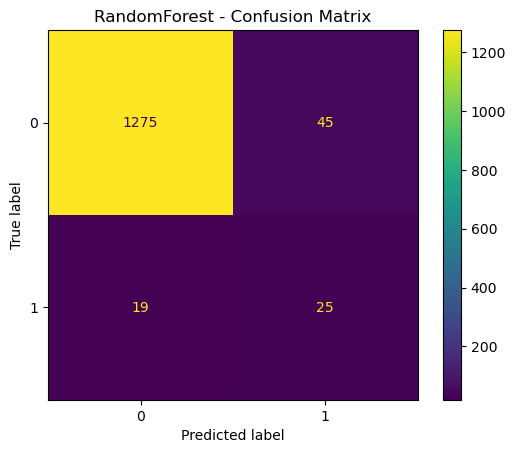

In [15]:
plots_dir = 'plots'
if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("RandomForest - Confusion Matrix")
plt.show()
# ... (plotting code remains the same) ...

## 6. Save Model and Assets

In [16]:
models_dir = 'models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
joblib.dump(scaler, os.path.join(models_dir, 'scaler.joblib'))
joblib.dump(top_10_feature_names, os.path.join(models_dir, 'top_10_features.joblib'))

['models\\top_10_features.joblib']

## 7. NEW: Create and Save SHAP Explainer

Here, we create a SHAP `TreeExplainer` which is optimized for tree-based models like Random Forest. We save this explainer object so the Streamlit app can load it to explain individual predictions.

In [17]:
print("Creating SHAP explainer...")
# We use the scaled training data to initialize the explainer for better background reference
explainer = shap.TreeExplainer(clf)
print("SHAP explainer created successfully.")

# Save the explainer object in the same directory as the model
explainer_path = os.path.join(models_dir, 'shap_explainer.joblib')
joblib.dump(explainer, explainer_path)
print(f"Explainer saved to {explainer_path}")

Creating SHAP explainer...
SHAP explainer created successfully.
Explainer saved to models\shap_explainer.joblib


## Additional Models for Accuracy Comparison
This section was appended to compare multiple models using the **same preprocessed data and splits** already defined above.


--- LogisticRegression ---
Accuracy: 0.967008797653959
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1320
           1       0.00      0.00      0.00        44

    accuracy                           0.97      1364
   macro avg       0.48      0.50      0.49      1364
weighted avg       0.94      0.97      0.95      1364



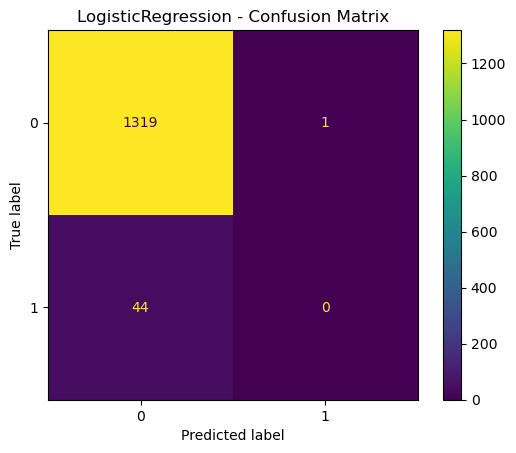


--- SVC ---
Accuracy: 0.967741935483871
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1320
           1       0.00      0.00      0.00        44

    accuracy                           0.97      1364
   macro avg       0.48      0.50      0.49      1364
weighted avg       0.94      0.97      0.95      1364



c:\Users\ander\anaconda3\envs\ml_study\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ander\anaconda3\envs\ml_study\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ander\anaconda3\envs\ml_study\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", res

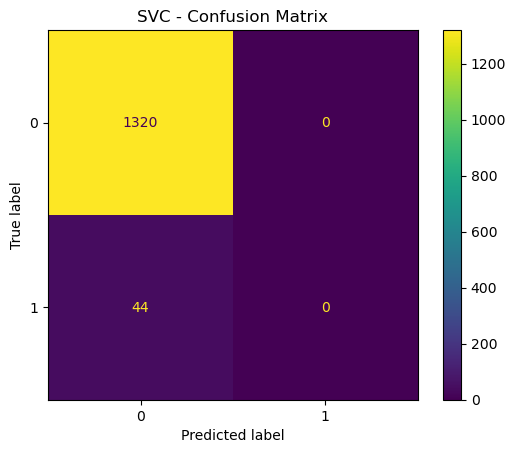


--- KNeighborsClassifier ---
Accuracy: 0.966275659824047
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1320
           1       0.45      0.23      0.30        44

    accuracy                           0.97      1364
   macro avg       0.71      0.61      0.64      1364
weighted avg       0.96      0.97      0.96      1364



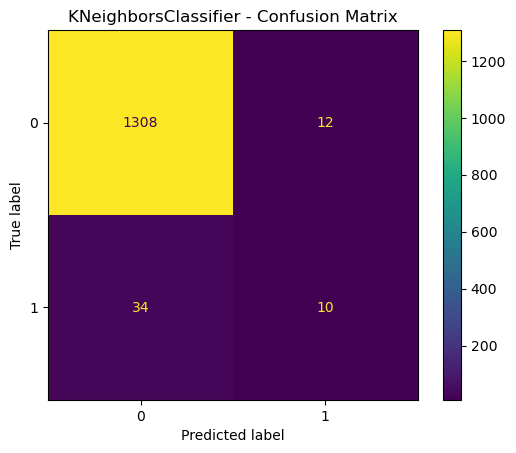


--- GradientBoostingClassifier ---
Accuracy: 0.9706744868035191
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1320
           1       0.59      0.30      0.39        44

    accuracy                           0.97      1364
   macro avg       0.78      0.64      0.69      1364
weighted avg       0.96      0.97      0.97      1364



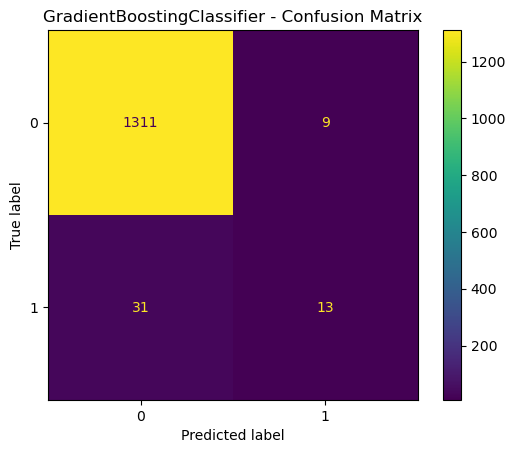

In [ ]:
# === Additional Model Comparison (appended without changing your original workflow) ===

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

logistic_regression = LogisticRegression(max_iter=200, n_jobs=None)
s_v_c = SVC(probability=True)
gradient_boosting_classifier = GradientBoostingClassifier(random_state=42)
k_neighbors_classifier = KNeighborsClassifier()


print("\n--- LogisticRegression ---")
logistic_regression.fit(X_train, y_train)
y_pred_logistic_regression = logistic_regression.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_logistic_regression))
print(classification_report(y_test, y_pred_logistic_regression))

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred_logistic_regression)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("LogisticRegression - Confusion Matrix")
plt.show()


print("\n--- SVC ---")
s_v_c.fit(X_train, y_train)
y_pred_s_v_c = s_v_c.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_s_v_c))
print(classification_report(y_test, y_pred_s_v_c))

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred_s_v_c)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("SVC - Confusion Matrix")
plt.show()


print("\n--- KNeighborsClassifier ---")
k_neighbors_classifier.fit(X_train, y_train)
y_pred_k_neighbors_classifier = k_neighbors_classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_k_neighbors_classifier))
print(classification_report(y_test, y_pred_k_neighbors_classifier))

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred_k_neighbors_classifier)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("KNeighborsClassifier - Confusion Matrix")
plt.show()


print("\n--- GradientBoostingClassifier ---")
gradient_boosting_classifier.fit(X_train, y_train)
y_pred_gradient_boosting_classifier = gradient_boosting_classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_gradient_boosting_classifier))
print(classification_report(y_test, y_pred_gradient_boosting_classifier))

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred_gradient_boosting_classifier)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("GradientBoostingClassifier - Confusion Matrix")
plt.show()


In [19]:
from sklearn.metrics import roc_auc_score

# ROC-AUC for Logistic Regression
if hasattr(logistic_regression, "predict_proba"):
    y_proba_logistic_regression = logistic_regression.predict_proba(X_test)[:, 1]
    roc_auc_logistic = roc_auc_score(y_test, y_proba_logistic_regression)
    print(f"LogisticRegression ROC-AUC: {roc_auc_logistic:.4f}")

# ROC-AUC for SVC
# SVC does not support predict_proba by default unless probability=True (which is set above).
# If your SVC was trained with probability=True, you can use predict_proba.
# Otherwise, use decision_function and scale to [0,1] via min-max normalization for ROC-AUC.

if hasattr(s_v_c, "predict_proba"):
    y_proba_svc = s_v_c.predict_proba(X_test)[:, 1]
    roc_auc_svc = roc_auc_score(y_test, y_proba_svc)
    print(f"SVC ROC-AUC: {roc_auc_svc:.4f}")
elif hasattr(s_v_c, "decision_function"):
    # Use decision_function and min-max scale to [0,1]
    dec_func = s_v_c.decision_function(X_test)
    dec_func_scaled = (dec_func - dec_func.min()) / (dec_func.max() - dec_func.min())
    roc_auc_svc = roc_auc_score(y_test, dec_func_scaled)
    print(f"SVC ROC-AUC (from decision_function): {roc_auc_svc:.4f}")
else:
    print("SVC does not support probability or decision_function for ROC-AUC.")

# ROC-AUC for Gradient Boosting
if hasattr(gradient_boosting_classifier, "predict_proba"):
    y_proba_gbc = gradient_boosting_classifier.predict_proba(X_test)[:, 1]
    roc_auc_gbc = roc_auc_score(y_test, y_proba_gbc)
    print(f"GradientBoostingClassifier ROC-AUC: {roc_auc_gbc:.4f}")

LogisticRegression ROC-AUC: 0.8663
SVC ROC-AUC: 0.5000
GradientBoostingClassifier ROC-AUC: 0.9383
